# First glance at Bayesian neural network
In this notebook we compare the non-Bayesian and Bayesian neural network which share similar architecture. Bayesian NN provides uncertainty in its prediction while non-Bayesian NN only provides point esitmates. MNIST dataset is used.

## 0.0 Import libraries and set plot format

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
from sklearn import datasets
import scipy.stats as ss
from tqdm import tqdm

tfd = tfp.distributions

In [37]:
print(tf.__version__)
print(tfp.__version__)

2.4.1
0.12.1


In [38]:
plt.style.use('ggplot')

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## 1.0 Load datasets

In [39]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32)/255., X_test.astype(np.float32)/255.

X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)
print(f"Training input data size is {X_train.shape}")
print(f"Training output data size is {y_train.shape}")

Training input data size is (60000, 28, 28, 1)
Training output data size is (60000,)


In [40]:
X_train.dtype

dtype('float32')

In [41]:
input_shape = X_train[0].shape
print(f'input shape is: {input_shape}')
print(f'outputs can be:  {set(y_train)}')

input shape is: (28, 28, 1)
outputs can be:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## 2.0 Non-Bayesian neural network model

### 2.1 Build non-Bayesian model

In [42]:
mymodel = keras.models.Sequential([
                                   layers.Conv2D(kernel_size=(3,3),filters=32,activation='relu',input_shape=input_shape),
                                   layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'),
                                   layers.Flatten(),
                                   layers.Dense(100,activation='relu'),
                                   layers.Dropout(0.2),
                                   layers.Dense(10, activation='softmax'),
            
])

In [43]:
def run_experiment(model,loss, X_train,y_train,X_test,y_test, epochs, patience):
  '''compile, fit, evaluate in one function''' 
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode = 'min', patience=patience)
  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=loss,
        metrics=['accuracy'],
    )
  print("training the model...")
  history = model.fit(X_train,y_train,validation_split=0.1,epochs=epochs,verbose=1,callbacks=[early_stop])
  print("evaluating model on train data")
  loss_t, acc_t = model.evaluate(X_train, y_train)
  print(f"Trainning loss: {loss_t :.3f}, training acc: {acc_t:.3f}")

  print("evaluating model on test data")
  loss_tt, acc_tt = model.evaluate(X_test, y_test)
  print(f"Testing loss: {loss_tt:.3f}, testing acc: {acc_tt:.3f}")
  return history

### 2.2 Run non-Bayesian model

In [44]:
loss='sparse_categorical_crossentropy'
start= time.time()
history = run_experiment(mymodel,loss, X_train,y_train,X_test,y_test,200,10)
time_cost = time.time()- start
print(f'Training cost {time_cost :.2f} seconds.')

training the model...
Epoch 1/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3881 - accuracy: 0.8815 - val_loss: 0.0619 - val_accuracy: 0.9822
Epoch 2/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0724 - accuracy: 0.9792 - val_loss: 0.0462 - val_accuracy: 0.9875
Epoch 3/200
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.0456 - val_accuracy: 0.9877
Epoch 4/200
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.0476 - val_accuracy: 0.9883
Epoch 5/200
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0290 - accuracy: 0.9900 - val_loss: 0.0531 - val_accuracy: 0.9872
Epoch 6/200
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.0445 - val_accuracy: 0.9898
Epoch 7/200
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0175 - accuracy: 0.9942 - val

In [45]:
mymodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

In [46]:
mymodel.save('Normal_CNN.h5')

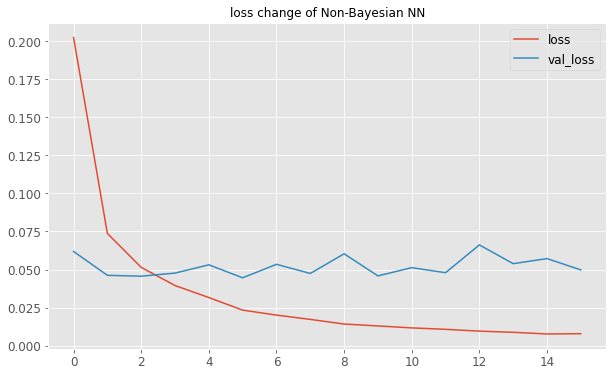

In [47]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(10,6))
plt.title("loss change of Non-Bayesian NN")
plt.show()

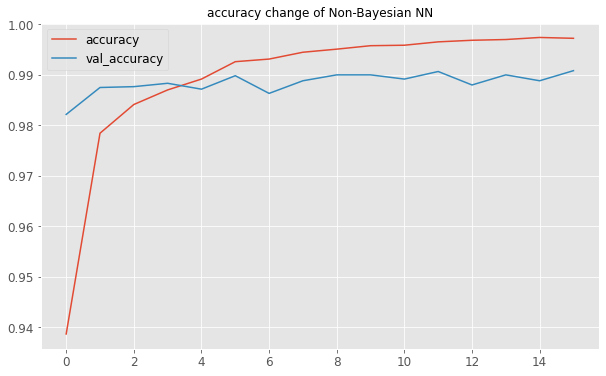

In [48]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(figsize=(10,6))
plt.title("accuracy change of Non-Bayesian NN")
plt.show()

### 2.3 The prediction of non-Bayesian model
we can see the prediction(take X_test[0] as an example) is the same all the time as the Non-Bayesian model provides point esitmation

In [49]:
for i in range(5):
  print(f"iter {i}")
  print(f"predicted label: {np.argmax(mymodel.predict(X_test)[0])}")
  print(f"predicted mat: {mymodel.predict(X_test)[0]}")
  

iter 0
predicted label: 7
predicted mat: [2.9812066e-13 2.4266643e-13 1.5029285e-11 3.6832851e-10 3.3333031e-16
 8.5711522e-17 9.2583576e-19 1.0000000e+00 8.7349545e-13 5.5102101e-10]
iter 1
predicted label: 7
predicted mat: [2.9812066e-13 2.4266643e-13 1.5029285e-11 3.6832851e-10 3.3333031e-16
 8.5711522e-17 9.2583576e-19 1.0000000e+00 8.7349545e-13 5.5102101e-10]
iter 2
predicted label: 7
predicted mat: [2.9812066e-13 2.4266643e-13 1.5029285e-11 3.6832851e-10 3.3333031e-16
 8.5711522e-17 9.2583576e-19 1.0000000e+00 8.7349545e-13 5.5102101e-10]
iter 3
predicted label: 7
predicted mat: [2.9812066e-13 2.4266643e-13 1.5029285e-11 3.6832851e-10 3.3333031e-16
 8.5711522e-17 9.2583576e-19 1.0000000e+00 8.7349545e-13 5.5102101e-10]
iter 4
predicted label: 7
predicted mat: [2.9812066e-13 2.4266643e-13 1.5029285e-11 3.6832851e-10 3.3333031e-16
 8.5711522e-17 9.2583576e-19 1.0000000e+00 8.7349545e-13 5.5102101e-10]


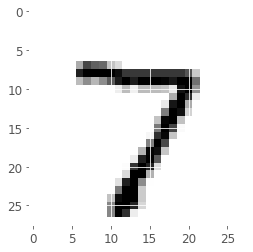

In [50]:
plt.imshow(X_test[0].reshape(28,28),cmap='binary')
plt.show()

## 3.0 Bayesian Neural Netwrok

### 3.1 Define prior and posterior for Densevairantion layers (can be skipped for now)
not used in BNN classification here

In [51]:
# prior is non-trainable, so we use tfp.layers.DistributionLambda
# multivariate normal distribution is often chosen
def prior(kernel_size, bias_size, dtype = None):
  n = kernel_size+bias_size
  prior_model = keras.models.Sequential([
                                         tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc = tf.zeros(n),scale_diag=tf.ones(n)))
  ])
  print(f'PRIOR: kerel size is {kernel_size}, bias size is {bias_size}\n ')
  return prior_model

# using tfp.layers.VariableLayer to create a trainable layer and followed by the layer
def posterior(kernel_size, bias_size, dtype = None):
  n = kernel_size+bias_size
  posterior_model = keras.models.Sequential([
                                             tfp.layers.VariableLayer(
                                                 tfp.layers.MultivariateNormalTriL.params_size(n),dtype=dtype
                                             ),
                                             tfp.layers.MultivariateNormalTriL(n)
  ])
  print(f'POSTERIOR: kerel size is {kernel_size}, bias size is {bias_size}\n ')
  return posterior_model

### 3.2 Define KL divergence for Denseflipout layers
prior and posterior are default in the layer

In [52]:
kernel_div_fn = lambda q,p,_: tfd.kl_divergence(q,p)/X_train.shape[0]

### 3.3 Build Bayesian model

In [53]:
# Sequential model, similar structure with the Non-Bayesian model, but no dropout, since VI(minimizing KL is used)
myBNN = keras.models.Sequential([
                                 tfp.layers.Convolution2DFlipout(filters=32,kernel_size=(3,3),padding='valid',activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 layers.MaxPooling2D(pool_size=(2,2),padding='valid',strides=None),
                                 layers.Flatten(),
                                 tfp.layers.DenseFlipout(100,activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 tfp.layers.DenseFlipout(10,activation='softmax',kernel_divergence_fn=kernel_div_fn) # 10 classes

])

### 3.4 Run Bayesian model


In [54]:
# same as Non-Bayesian model
loss='sparse_categorical_crossentropy'
myBNN.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=loss,
      metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(name='Cat_Etp'),'accuracy'],
  )

In [55]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode = 'max', patience=5)
print("training the model...")
BNNhistory = myBNN.fit(X_train,y_train,validation_split=0.1,epochs=200,verbose=1,callbacks=[early_stop])

training the model...
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


1688/1688 [==============================] - 10s 5ms/step - loss: 21.2851 - Cat_Etp: 0.5423 - accuracy: 0.8233 - val_loss: 14.5478 - val_Cat_Etp: 0.0894 - val_accuracy: 0.9738
Epoch 2/200
1688/1688 [==============================] - 8s 5ms/step - loss: 12.7546 - Cat_Etp: 0.0971 - accuracy: 0.9702 - val_loss: 8.2657 - val_Cat_Etp: 0.0715 - val_accuracy: 0.9783
Epoch 3/200
1688/1688 [==============================] - 8s 5ms/step - loss: 7.3176 - Cat_Etp: 0.0729 - accuracy: 0.9769 - val_loss: 5.1667 - val_Cat_Etp: 0.0763 - val_accuracy: 0.9773
Epoch 4/200
1688/1688 [==============================] - 8s 5ms/step - loss: 4.6989 - Cat_Etp: 0.0663 - accuracy: 0.9800 - val_loss: 3.5855 - val_Cat_Etp: 0.0790 - val_accuracy: 0.9773
Epoch 5/200
1688/1688 [==============================] - 8s 5ms/step - loss: 3.3023 - Cat_Etp: 0.0625 - accuracy: 0.9783 - val_loss: 2.6467 - val_Cat_Etp: 0.0786 - val_accuracy: 0.9788
Epoch 6/200
1688/1688 [==============================] - 8s 5ms/step - loss: 2.4643

In [56]:
print("evaluating model on test data")
loss_tt, Cat_Etp, acc_tt = myBNN.evaluate(X_test, y_test)
print(f"Testing loss: {loss_tt:.3f}, testing acc: {acc_tt:.3f}")

evaluating model on test data
313/313 [==============================] - 1s 3ms/step - loss: 0.6111 - Cat_Etp: 0.0825 - accuracy: 0.9763
Testing loss: 0.611, testing acc: 0.976


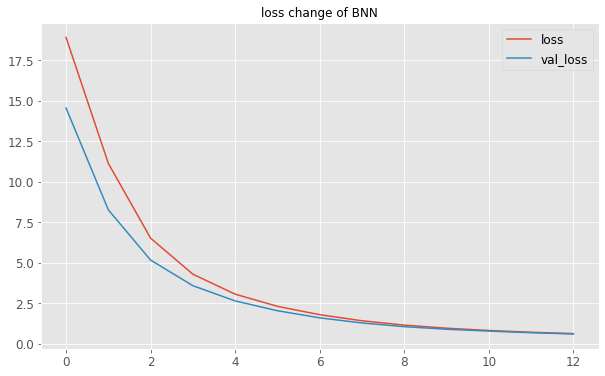

In [57]:
pd.DataFrame(BNNhistory.history)[['loss','val_loss']].plot(figsize=(10,6))
plt.title("loss change of BNN")
plt.legend()
plt.show()

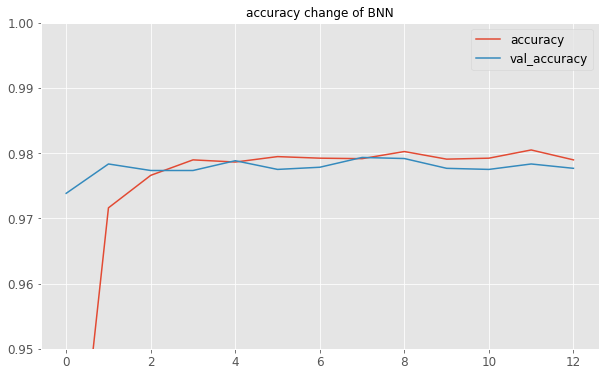

In [58]:
pd.DataFrame(BNNhistory.history)[['accuracy','val_accuracy']].plot(figsize=(10,6))
plt.title("accuracy change of BNN")
plt.ylim(0.95,1)
plt.legend()
plt.show()

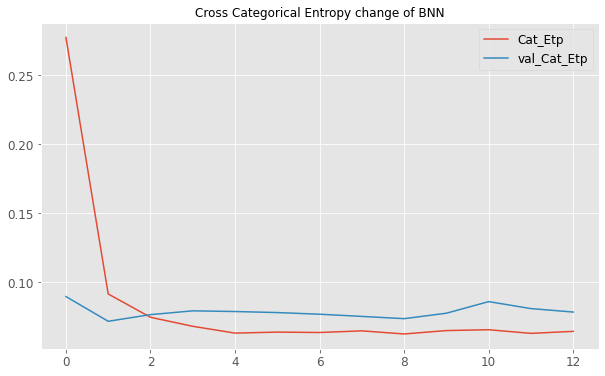

In [59]:
pd.DataFrame(BNNhistory.history)[['Cat_Etp','val_Cat_Etp']].plot(figsize=(10,6))
plt.title("Cross Categorical Entropy change of BNN")
plt.legend()
plt.show()

Note that every weight in the network is now sampled from a normal distribution. The normal distribution has two paramters and therefore we have almost doubled our paramters (we don't use a distribution for bias terms) in the network. 

In [60]:
myBNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 26, 26, 32)        608       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 100)               1081700   
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 10)                2010      
Total params: 1,084,318
Trainable params: 1,084,318
Non-trainable params: 0
_________________________________________________________________


In [61]:
myBNN.save('Bayesian_CNN.h5')

### 3.5 The prediction of Bayesian model

we can see the distribution variates every time, so we run model.predict 50 time and calculate the mean and std

In [62]:
for i in range(5):
  print(f"iter {i}")
  print(f"predicted label: {np.argmax(myBNN.predict(X_test)[0])}")
  print(f"predicted mat: {myBNN.predict(X_test)[0]}")

iter 0
predicted label: 7
predicted mat: [5.2457055e-10 1.5984302e-08 4.6855840e-07 8.0754754e-09 1.9600828e-11
 1.6784928e-11 2.1923887e-15 9.9999952e-01 7.4856704e-11 1.6420231e-08]
iter 1
predicted label: 7
predicted mat: [2.85207108e-07 5.41888312e-06 3.69237358e-04 3.22879059e-04
 4.42147474e-09 1.94733687e-08 1.04162567e-10 9.99289751e-01
 1.12793805e-05 1.09590576e-06]
iter 2
predicted label: 7
predicted mat: [3.9584656e-09 1.0939628e-07 3.8393546e-06 2.3624561e-06 6.6433181e-10
 1.7833178e-10 4.5917068e-13 9.9999321e-01 5.5033091e-08 4.0211361e-07]
iter 3
predicted label: 7
predicted mat: [3.4216588e-10 1.6334364e-07 2.0281982e-06 1.4054432e-07 1.7117481e-11
 6.2784992e-11 5.9684625e-14 9.9999750e-01 8.8515799e-09 5.4865737e-08]
iter 4
predicted label: 7
predicted mat: [1.5234047e-11 3.4100902e-09 3.1271443e-07 3.5005872e-08 3.4040735e-12
 1.8767481e-12 3.3218990e-18 9.9999952e-01 1.5048332e-10 1.0674973e-07]


#### 3.5.1 Run model.evaluate 50 times directly
then calculate the mean and std fo accuracy, loss

In [63]:
# myBNN= keras.models.load_model('/content/Bayesian_CNN.h5') # not working in Google Colab, reason unknown

In [64]:
acc_tt_esb=[]
loss_tt_esb = []
for i in tqdm(range(50)):
  acc_tt_esb.append(myBNN.evaluate(X_test, y_test,verbose=0)[2])
  loss_tt_esb.append(myBNN.evaluate(X_test, y_test,verbose=0)[0])

acc_tt_esb = np.array(acc_tt_esb)
acc_mean = np.mean(acc_tt_esb)
acc_std = np.std(acc_tt_esb,ddof=1)

loss_tt_esb = np.array(loss_tt_esb)
loss_mean = np.mean(loss_tt_esb)
loss_std = np.std(loss_tt_esb,ddof=1)

print(f'the mean and std of predcion accuracy are: {acc_mean :.3f}, {acc_std :.6f}')
print(f'the mean and std of predcion loss are: {loss_mean :.3f}, {loss_std :.6f}')


100%|██████████| 50/50 [01:20<00:00,  1.62s/it]

the mean and std of predcion accuracy are: 0.975, 0.001013
the mean and std of predcion loss are: 0.612, 0.003421


### 3.6 Plot the result

#### 3.6.1 Prepare data for each digit number

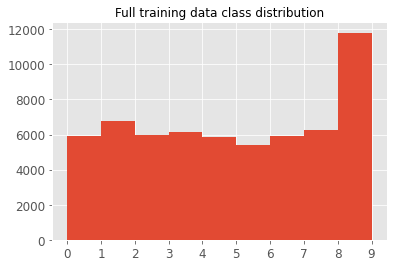

In [65]:
plt.hist(y_train,bins=[0,1,2,3,4,5,6,7,8,9])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.title("Full training data class distribution")
plt.show()

In [66]:
keys = ['idx_0','idx_1','idx_2','idx_3','idx_4','idx_5','idx_6','idx_7','idx_8','idx_9']
cat_dic = {}
for i in range(10):
  cat_dic[keys[i]]=np.array(np.where(y_test == i)).reshape(-1)

In [67]:
pred_loss=np.zeros((10,10))
pred_cat_etp = np.zeros((10,10))
cat_acc =np.zeros((10,10))

for i in tqdm(range(10)):
  for k in range(10):
    pred_loss1,pred_cat_etp1, cat_acc1 = myBNN.evaluate(X_test[cat_dic[keys[k]]],y_test[np.where(y_test==k)],verbose=0)
    pred_loss[i,k] = pred_loss1
    pred_cat_etp[i,k]=pred_cat_etp1
    cat_acc[i,k]=cat_acc1



100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


In [68]:
cat_acc_mean = cat_acc.mean(axis=1)
cat_acc__std = cat_acc.std(axis=1)

#### 3.6.2 Visualize the mean and std for each digit

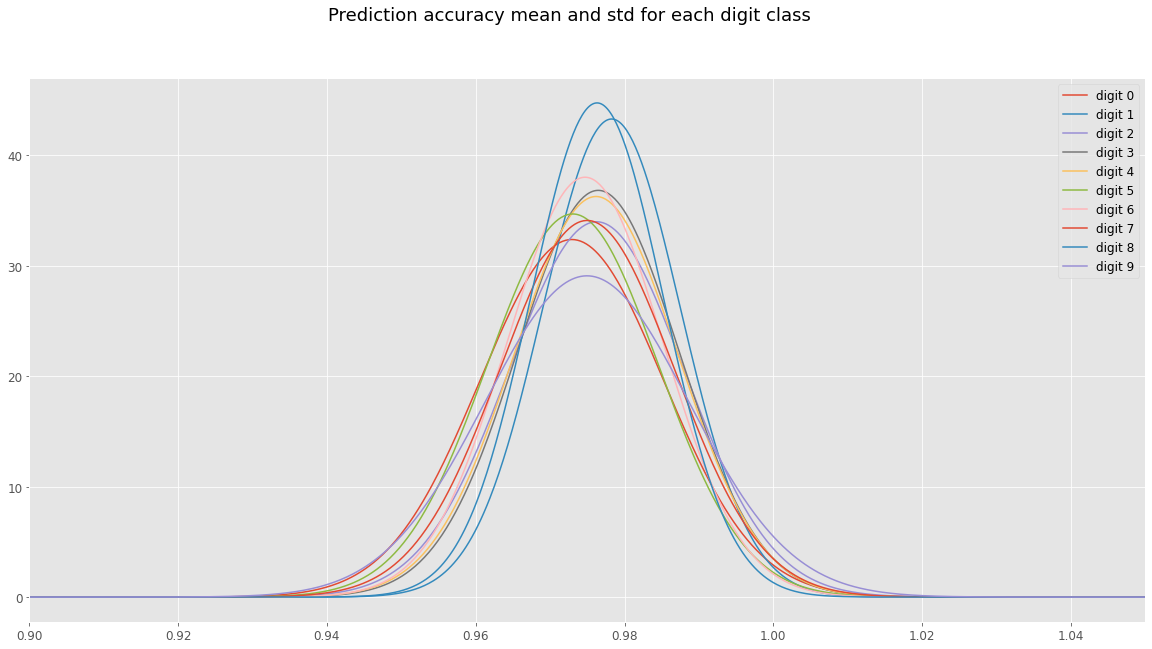

In [69]:
plt.figure(figsize=(20,10))
plt.suptitle("Prediction accuracy mean and std for each digit class")
x = np.linspace(0,2,10000)
for i in range(10):
  plt.plot(x, ss.norm.pdf(x,cat_acc_mean[i],cat_acc__std[i]),label=f'digit {i}')
  plt.legend()
  plt.xlim(0.9,1.05)
  # plt.legend()
plt.show()

#### 3.6.3 Visulize the histogram of prediction for each digit
easy to see the wrong prediction label, then we can tell wether the wrong prediction makes sense

In [70]:
pred_dic={}
for k in cat_dic.keys():
  pred_dic[k] = np.argmax(myBNN(X_test[cat_dic[k]]).numpy(),axis=1)

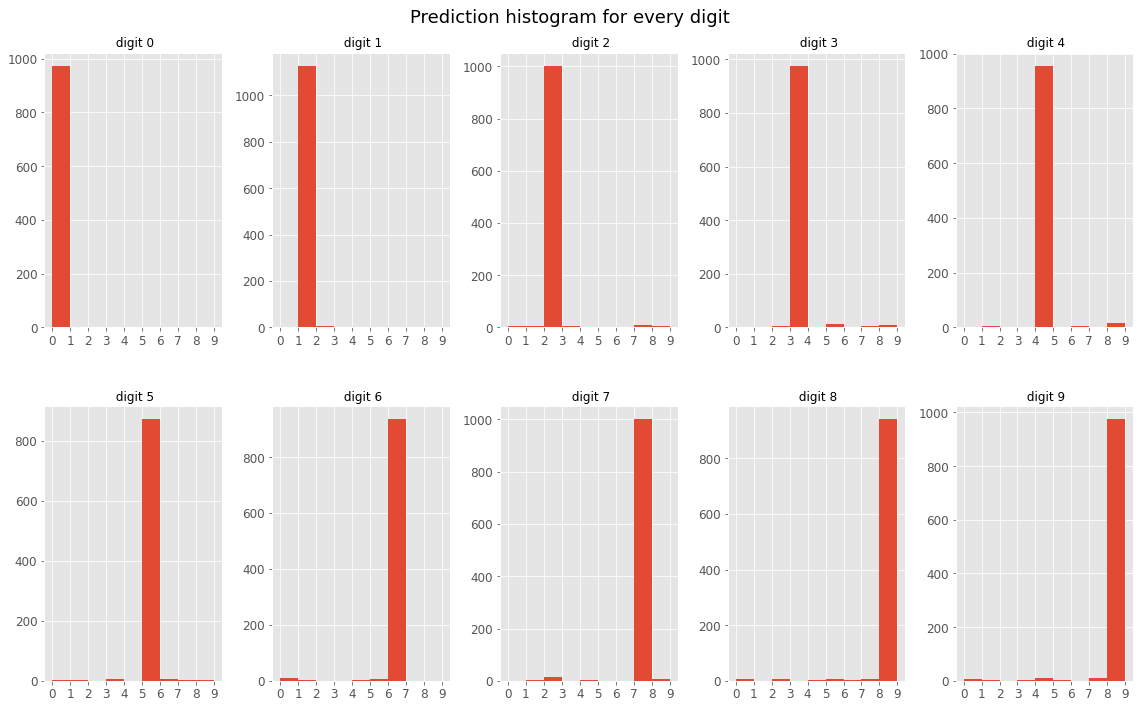

In [71]:
plt.figure(figsize=(16, 10))
plt.suptitle('Prediction histogram for every digit\n',y=0.98)
for i in range(10):
  plt.subplot(2,5, i+1)
  plt.hist(pred_dic[keys[i]],density=False,bins=[0,1,2,3,4,5,6,7,8,9])
  # sns.distplot(pred_dic[keys[i]],bins=[0,1,2,3,4,5,6,7,8,9])
  plt.title(f'\n \n digit {i}')
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.tight_layout()

plt.show()

In [72]:
X_test[cat_dic[keys[0]]].shape

(980, 28, 28, 1)

## 4.0 Predction on unseen data
we can see big standard deviation in prediction in Bayesian NN, while we only get one point estimation for non-Bayesian NN

In [78]:
# generate unseen data
unseen_digit = np.zeros((1,28,28,1))
loc = np.random.choice(28,(40,2))
col = np.random.choice((150,255),40)
for i in range(40):
  unseen_digit[0,loc[i][0],loc[i][1],0]= col[i]

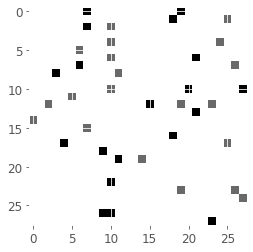

In [79]:
plt.imshow(unseen_digit.reshape(28,28),cmap='binary')
plt.show()

#### 4.1 Bayesian model
the prediction shows large variation, meaning low confidence and high uncertainty

In [89]:
unseen_pred = np.zeros((1000,1))
for i in tqdm(range(1000)):
  unseen_pred[i,0] = np.argmax(myBNN.predict(unseen_digit),axis=1)

100%|██████████| 1000/1000 [00:31<00:00, 31.91it/s]


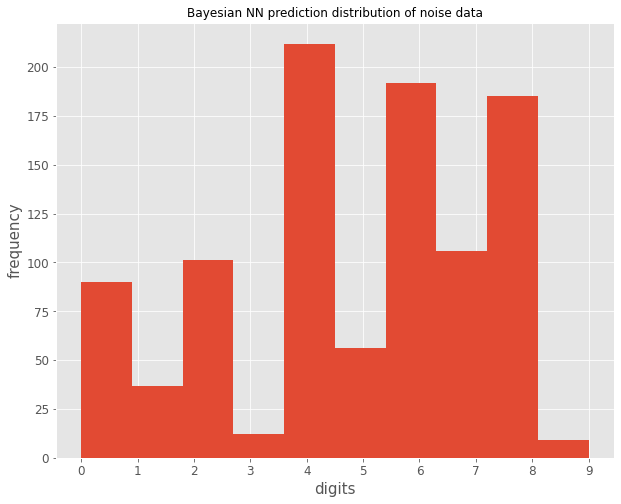

In [96]:
plt.figure(figsize=(10,8))
plt.hist(unseen_pred)
plt.title('Bayesian NN prediction distribution of noise data')
plt.ylabel("frequency")
plt.xlabel("digits")
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

#### 4.2 Non-Bayesian model
point estimate of 6, and even the softmax matric shows 100% for digit 6

In [103]:
unseen_pred_nonBayesian = mymodel.predict(unseen_digit)[0]

In [104]:
unseen_pred_nonBayesian

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## 4.0 Probabilisitic Bayesian neural network
Try to use tfp.layers.OneHotCategorical() to output distribution of prediction directly, but the model is not learning. <br/>
Refecence at [Keras blog](https://keras.io/examples/keras_recipes/bayesian_neural_networks/), experiment 3

In [ ]:
# Sequential model, similar structure with the Non-Bayesian model, but no dropout, since VI(minimizing KL is used)
myProbBNN = keras.models.Sequential([
                                 tfp.layers.Convolution2DFlipout(filters=32,kernel_size=(3,3),padding='valid',activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 layers.MaxPooling2D(pool_size=(2,2),padding='valid',strides=None),
                                 layers.Flatten(),
                                 tfp.layers.DenseFlipout(100,activation='relu',kernel_divergence_fn=kernel_div_fn),
                                 tfp.layers.DenseFlipout(tfp.layers.OneHotCategorical.params_size(10),kernel_divergence_fn=kernel_div_fn,activation='relu'),
                                 tfp.layers.OneHotCategorical(10)
])

In [ ]:
def neg_log_lik(y_true, y_pred): 
  return - y_pred.log_prob(y_true)

In [ ]:
myProbBNN.compile(optimizer='Adam',loss=neg_log_lik,metrics=['accuracy'])

In [ ]:
probBNNHistory = myProbBNN.fit(X_train,y_train,validation_split=0.1,epochs=200,callbacks=[early_stop])

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


1688/1688 [==============================] - 11s 5ms/step - loss: 7688676.6963 - accuracy: 0.1006 - val_loss: 73151312.0000 - val_accuracy: 0.0975
Epoch 2/200
1688/1688 [==============================] - 9s 5ms/step - loss: 110135516.8028 - accuracy: 0.1002 - val_loss: 241581440.0000 - val_accuracy: 0.0993
Epoch 3/200
1688/1688 [==============================] - 9s 5ms/step - loss: 294189202.9272 - accuracy: 0.1041 - val_loss: 469680288.0000 - val_accuracy: 0.0972
Epoch 4/200
1688/1688 [==============================] - 9s 5ms/step - loss: 533735070.0675 - accuracy: 0.0975 - val_loss: 748003264.0000 - val_accuracy: 0.1037
Epoch 5/200
1688/1688 [==============================] - 9s 5ms/step - loss: 822682305.0989 - accuracy: 0.0984 - val_loss: 1075418880.0000 - val_accuracy: 0.1008
Epoch 6/200
1688/1688 [==============================] - 9s 5ms/step - loss: 1159162235.5287 - accuracy: 0.1027 - val_loss: 1448762496.0000 - val_accuracy: 0.0975
Epoch 7/200
1688/1688 [======================